# [ResNet]

*KU LeeDongGyu*

## Contents
---

1. Data Import
2. Almost Original ResNet18 & Support Functions
```
1) Support Functions
2-1) ResNet18 - Naive code
2-2) ResNet18 - Advanced code
2-3) ResNet18 - More Advanced code
2-4) Graph
```
3. My Function
4. For Size = 64,
```
1) My ResNet18
2) My ResNet34
3) My ResNet50
```
5. For Size = 48,
```
1) My ResNet18
2) My ResNet34
3) My ResNet50
```
6. For Size = 48 , No Early Stopping
```
1) Epoch = 50
      (1) My ResNet18 
      (2) My ResNet34
      (3) My ResNet50
2) Epoch = 100
      (1) My ResNet18 
      (2) My ResNet34
      (3) My ResNet50
```

### Install Packages

In [126]:
pip install pydot  # plot_model 에서 쓸 패키지 

In [127]:
pip install graphviz # plot_model 에서 쓸 패키지

### Module

In [128]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [129]:
cd /content/drive/My Drive/Colab Notebooks/project

/content/drive/My Drive/Colab Notebooks/project
/content/drive/My Drive/Colab Notebooks/project


In [0]:
import sys

In [131]:
# 모듈로 받을 경로 확인
sys.path

['',
 '/env/python',
 '/usr/lib/python36.zip',
 '/usr/lib/python3.6',
 '/usr/lib/python3.6/lib-dynload',
 '/usr/local/lib/python3.6/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.6/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/content/drive/My Drive/Colab Notebooks/project']

['',
 '/env/python',
 '/usr/lib/python36.zip',
 '/usr/lib/python3.6',
 '/usr/lib/python3.6/lib-dynload',
 '/usr/local/lib/python3.6/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.6/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/content/drive/My Drive/Colab Notebooks/project',
 '/content/drive/My Drive/Colab Notebooks/project']

In [0]:
# 내 노트북이 아닌, 전산실 컴퓨터의 colab에서 돌렸으므로, 다시돌리려면 경로 수정할것!
sys.path.append("/content/drive/My Drive/Colab Notebooks/project")

In [0]:
from pool_helper import PoolHelper
from f1score import macro_f1score,weighted_f1score

In [0]:
import pandas as pd
import numpy as np
import cv2
import tensorflow as tf
from tensorflow import keras as ks
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Activation , Flatten
from tensorflow.keras.layers import AveragePooling2D, Input, ZeroPadding2D, MaxPooling2D
from tensorflow.keras.layers import add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping , LearningRateScheduler
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical
import numpy as np
import os

In [135]:
os.getcwd()

'/content/drive/My Drive/Colab Notebooks/project'

'/content/drive/My Drive/Colab Notebooks/project'

## 1. Data Import
---

In [0]:
# data import
x_train = pd.read_csv("mydata/X_train.csv",header=0,index_col=0)
x_valid = pd.read_csv("mydata/X_private_test.csv",header=0,index_col=0)
x_test = pd.read_csv("mydata/X_public_test.csv",header=0,index_col=0)
y_train = pd.read_csv("mydata/y_train.csv",header=0,index_col=0)
y_valid = pd.read_csv("mydata/y_private_test.csv",header=0,index_col=0)
y_test = pd.read_csv("mydata/y_public_test.csv",header=0,index_col=0)

In [0]:
# data handling
x_train = np.array(x_train).reshape([-1,48,48,3]) 
x_valid = np.array(x_valid).reshape([-1,48,48,3]) 
x_test = np.array(x_test).reshape([-1,48,48,3]) 

y_train=to_categorical(y_train) # one hot encoding
y_valid=to_categorical(y_valid)
y_test=to_categorical(y_test)

In [0]:
# data handling
# uint는 부호없는 정수로, 타입을 바꿔줘야함!
size = 64

In [0]:
x_train_zoom = np.zeros([x_train.shape[0],size,size,3],dtype="float32")
for i in range(x_train.shape[0]):
    x_train_zoom[i,:] = cv2.resize(x_train[i,:].astype('uint8'), (size, size),
                                  interpolation=cv2.INTER_CUBIC).reshape(size,size,3) /255

In [0]:
x_train = x_train / 255

In [0]:
x_valid = np.array(x_valid).reshape([-1,48,48,3])
x_valid_zoom = np.zeros([x_valid.shape[0],size,size,3],dtype="float32")
for i in range(x_valid.shape[0]):
    x_valid_zoom[i,:] = cv2.resize(x_valid[i,:].astype('uint8'), (size, size),
                                  interpolation=cv2.INTER_CUBIC).reshape(size,size,3) /255

In [0]:
 x_valid = x_valid / 255

In [0]:
x_test = np.array(x_test).reshape([-1,48,48,3])
x_test_zoom = np.zeros([x_test.shape[0],size,size,3],dtype="float32")
for i in range(x_test.shape[0]):
    x_test_zoom[i,:] = cv2.resize(x_test[i,:].astype('uint8'), (size, size),
                                  interpolation=cv2.INTER_CUBIC).reshape(size,size,3) / 255

In [0]:
x_test = x_test / 255

## 2. Almost Original ResNet18 & Support Functions

### 1) Support Functions

In [0]:
# learning rate는 적당한 epoch를 돌리고나면, 급격히 줄임으로써 좀더 세밀한 지역의 최적화를 이어나간다.
# 고차원 loss function의 모습은 fractal처럼 맞물려있기 때문.
# 이를 learning decay라 부름.
def lr_schedule(epoch):
    lr = 1e-2
    if epoch > 80:
        lr *= 0.5e-3
    elif epoch > 60:
        lr *= 1e-3
    elif epoch > 40:
        lr *= 1e-2
    elif epoch > 20:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [0]:
###### naive , advanced, more advanced function들에 모두 들어간다. ######


# 편의상 아래와 같은 resnet 묶음의 이름을 resnet_layer이라 하자 
def resnet_layer(inputs, num_filters=16,kernel_size=(3,3),strides=(1,1),activation=None,kernel_regularizer=l2(1e-4)):

    conv = Conv2D(num_filters,kernel_size=kernel_size,strides=strides, padding='same',
                  kernel_initializer='glorot_uniform', kernel_regularizer=kernel_regularizer)
    x = inputs
    x = conv(x)
    x = BatchNormalization()(x)
    if activation is not None:
        x = Activation(activation)(x) # conv-bn-activatio
    return x

In [0]:
###### advanced, more advanced function들에 모두 들어간다. ######
######  more advanced function 는 for문을 이용해서 더 줄였다. ######




# 내 데이터에 맞는 resnet18 코드를 만들기 앞서, 코드가 너무 길어 비효율적이므로 적당한 함수를 만든다.
# block_v1 은 resnet18과 resnet34에 특화된 block이고, block_v2는 resnet50, resnet101, resnet152에 특화된 block이다.
# 이 두개의 block은, 나중에 하나의 모형에서 같이 고려될 것이다.

def block_v1(input_shape, num_filters, identi, half=True, kernel_size= (3,3)):
    # identi : resnet의 존재 이유인, 더하게 될 자기자신값이다.
    if half:
        layer1 = resnet_layer(inputs=input_shape, num_filters=num_filters, strides=(2, 2), kernel_size=kernel_size,
                              activation='relu')
        layer2 = resnet_layer(inputs=layer1, num_filters=num_filters, strides=(1, 1), kernel_size=kernel_size,
                              activation=None)
    else:
        layer1 = resnet_layer(inputs=input_shape, num_filters=num_filters, strides=(1, 1), kernel_size=kernel_size,
                              activation='relu')
        layer2 = resnet_layer(inputs=layer1, num_filters=num_filters, strides=(1, 1), kernel_size=kernel_size,
                              activation=None)
    res_2_1 = add([identi, layer2])  # block 1
    output = Activation("relu")(res_2_1)
    return output


def block_v2(input_shape, num_filters, identi, half=True):
    # identi : resnet의 존재 이유인, 더하게 될 자기자신값이다.
    if half:
        layer1 = resnet_layer(inputs=input_shape, num_filters=num_filters, strides=(2, 2), kernel_size=(1, 1),
                              activation='relu')
        layer2 = resnet_layer(inputs=layer1, num_filters=num_filters, strides=(1, 1), kernel_size=(3, 3),
                              activation='relu')
        layer3 = resnet_layer(inputs=layer2, num_filters= 4*num_filters, strides=(1, 1), kernel_size=(1, 1),
                              activation=None)
    else:
        layer1 = resnet_layer(inputs=input_shape, num_filters= num_filters, strides=(1, 1), kernel_size=(1, 1),
                              activation='relu')
        layer2 = resnet_layer(inputs=layer1, num_filters= num_filters, strides=(1, 1), kernel_size=(3, 3),
                              activation='relu')
        layer3 = resnet_layer(inputs=layer2, num_filters= 4*num_filters, strides=(1, 1), kernel_size=(1, 1),
                              activation=None)
    res_2_1 = add([identi, layer3])  # block 1
    output = Activation("relu")(res_2_1)
    return output


### 2-1) ResNet18 - Naive code

In [0]:

# 1-1). Original ResNet18
def resnet18(input_shape=(224,224,3), classes=1000):

    inputs = Input(shape=input_shape)

    # conv1
    layer1 = resnet_layer(inputs=inputs,num_filters=64, strides=(2,2), kernel_size=(7,7),activation='relu')
    conv1_zero_pad = ZeroPadding2D(padding=(1, 1))(layer1)
    pool1_helper = PoolHelper()(conv1_zero_pad)
    pool_1 = MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid', name='pool1/3x3_s2')(pool1_helper)

    # 변수, layer_a_b_c 에서    a : conv number , b : block number , c : layer number 이다.
    # 변수, res_a_b 에서        a : conv number , b : block number ( = res number) 이다.
    # 변수, acti_a_b 에서       a : conv number , b : number between blocks 이다.
    # 이 사실을 기억하고, 아래의 변수들을 해석한다.

    # conv2_x
    layer_2_1_1 = resnet_layer(inputs=pool_1, num_filters=64, strides=(1,1), kernel_size=(3,3), activation='relu')
    layer_2_1_2 = resnet_layer(inputs=layer_2_1_1, num_filters=64, strides=(1,1), kernel_size=(3,3), activation=None)
    res_2_1 = add([pool_1, layer_2_1_2]) # block 1
    acti_2_1 = Activation("relu")(res_2_1)
    layer_2_2_1 = resnet_layer(inputs=acti_2_1, num_filters=64, strides=(1,1), kernel_size=(3,3), activation='relu')
    layer_2_2_2 = resnet_layer(inputs=layer_2_2_1, num_filters=64, strides=(1,1), kernel_size=(3,3), activation=None)
    res_2_2 = add([acti_2_1, layer_2_2_2]) # block 2 // 그리고 이런 규칙은 아래에서도 적용된다.
    acti_2_output = Activation('relu')(res_2_2)

    # 변수 identi_3_input 은 conv3_x 묶음에 처음으로 들어올 input이다. 이 값은 변환 없이 자기 자신을 유지한 채로 간다.

    # conv3_x
    identi_3_input = Conv2D(128, (1, 1), strides=(2, 2), padding='valid')(acti_2_output) # 차원을 맞춰주기 위해 convolution 연산 추가. (그대로 가는것)
    #identi_3_input = BatchNormalization()(identi_3_input) # 모든 conv.뒤에는 bn을 적용.
    layer_3_1_1 = resnet_layer(inputs=acti_2_output, num_filters=128, strides=(2,2), kernel_size=(3,3),activation='relu') #이 아래 두층은 rensnet층
    layer_3_1_2 = resnet_layer(inputs=layer_3_1_1, num_filters=128, strides=(1,1), kernel_size=(3,3), activation=None)
    res_3_1 = add([identi_3_input, layer_3_1_2])
    acti_3_1 = Activation("relu")(res_3_1)
    layer_3_2_1 = resnet_layer(inputs=acti_3_1,num_filters=128, strides=(1,1), kernel_size=(3,3), activation='relu') #이 아래 두층은 rensnet층
    layer_3_2_2 = resnet_layer(inputs=layer_3_2_1, num_filters=128, strides=(1,1), kernel_size=(3,3), activation=None)
    res_3_2 = add([acti_3_1, layer_3_2_2])
    acti_3_output = Activation('relu')(res_3_2)

    # conv4_x
    identi_4_input = Conv2D(256, (1, 1), strides=(2, 2), padding='valid')(acti_3_output) # 차원을 맞춰주기 위해 convolution 연산 추가. (그대로 가는것)
    #identi_4_input = BatchNormalization()(identi_4_input) # 모든 conv.뒤에는 bn을 적용.
    layer_4_1_1 = resnet_layer(inputs=acti_3_output, num_filters=256, strides=(2,2), kernel_size=(3,3),activation='relu') #이 아래 두층은 rensnet층
    layer_4_1_2 = resnet_layer(inputs=layer_4_1_1, num_filters=256, strides=(1,1), kernel_size=(3,3), activation=None)
    res_4_1 = add([identi_4_input, layer_4_1_2])
    acti_4_1 = Activation("relu")(res_4_1)
    layer_4_2_1 = resnet_layer(inputs=acti_4_1,num_filters=256, strides=(1,1), kernel_size=(3,3), activation='relu') #이 아래 두층은 rensnet층
    layer_4_2_2 = resnet_layer(inputs=layer_4_2_1, num_filters=256, strides=(1,1), kernel_size=(3,3), activation=None)
    res_4_2 = add([acti_4_1, layer_4_2_2])
    acti_4_output = Activation('relu')(res_4_2)

    # conv5_x
    identi_5_input = Conv2D(512, (1, 1), strides=(2, 2), padding='valid')(acti_4_output) # 차원을 맞춰주기 위해 convolution 연산 추가. (그대로 가는것)
    #identi_5_input = BatchNormalization()(identi_5_input) # 모든 conv.뒤에는 bn을 적용.
    layer_5_1_1 = resnet_layer(inputs=acti_4_output, num_filters=512, strides=(2,2), kernel_size=(3,3),activation='relu') #이 아래 두층은 rensnet층
    layer_5_1_2 = resnet_layer(inputs=layer_5_1_1, num_filters=512, strides=(1,1), kernel_size=(3,3), activation=None)
    res_5_1 = add([identi_5_input, layer_5_1_2])
    acti_5_1 = Activation("relu")(res_5_1)
    layer_5_2_1 = resnet_layer(inputs=acti_5_1,num_filters=512, strides=(1,1), kernel_size=(3,3), activation='relu') #이 아래 두층은 rensnet층
    layer_5_2_2 = resnet_layer(inputs=layer_5_2_1, num_filters=512, strides=(1,1), kernel_size=(3,3), activation=None)
    res_5_2 = add([acti_5_1, layer_5_2_2])
    acti_5_output = Activation('relu')(res_5_2)

    # 마지막 1층
    y=AveragePooling2D(pool_size=(7, 7), strides=(1, 1), name='loss1/ave_pool')(acti_5_output)
    y = Flatten()(y)
    outputs = Dense(classes, activation='softmax', kernel_initializer='glorot_uniform')(y)

    model = Model(inputs=inputs, outputs=outputs)
    return model

In [0]:
model = resnet18(input_shape=(224,224,3),classes=1000)

In [150]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_80 (Conv2D)              (None, 112, 112, 64) 9472        input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_68 (BatchNo (None, 112, 112, 64) 256         conv2d_80[0][0]                  
__________________________________________________________________________________________________
activation_68 (Activation)      (None, 112, 112, 64) 0           batch_normalization_68[0][0]     
____________________________________________________________________________________________

### 2-2) ResNet18 - Advanced code

In [0]:
# 아래의 resnet18은, block_v1이 사용되었다.
# 함수의 이름에서 주목할 수 있듯, 이 모형은 resnet18밖에 사용하지 못함. 
# 이를 해결한 모형은 2-3)에서 더 간단한 형태로 제시된다.


def resnet18(input_shape=(224, 224, 3), classes=1000):
    inputs = Input(shape=input_shape)

    # conv1
    layer1 = resnet_layer(inputs=inputs, num_filters=64, strides=(2, 2), kernel_size=(7, 7), activation='relu')
    conv1_zero_pad = ZeroPadding2D(padding=(1, 1))(layer1)
    pool1_helper = PoolHelper()(conv1_zero_pad)
    pool_1 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid', name='pool1/3x3_s2')(pool1_helper)

    # 변수, block_a_b 에서    a : conv number , b : block number 이다.
    # conv2_x
    block_2_1 = block_v1(input_shape=pool_1, num_filters=64, identi=pool_1, half=False, kernel_size=(3, 3))
    block_2_2 = block_v1(input_shape=block_2_1, num_filters=64, identi=block_2_1, half=False, kernel_size=(3, 3))

    # conv3_x
    identi_3_input = Conv2D(128, (1, 1), strides=(2, 2), padding='valid')(block_2_2)  # 차원을 맞춰주기 위해 convolution 연산 추가. (그대로 가는것)
    #identi_3_input = BatchNormalization()(identi_3_input) # 모든 conv.뒤에는 bn을 적용.
    block_3_1 = block_v1(input_shape=block_2_2, num_filters=128, identi=identi_3_input, half=True, kernel_size=(3, 3))
    block_3_2 = block_v1(input_shape=block_3_1, num_filters=128, identi=block_3_1, half=False, kernel_size=(3, 3))

    # conv4_x
    identi_4_input = Conv2D(256, (1, 1), strides=(2, 2), padding='valid')(block_3_2)  # 차원을 맞춰주기 위해 convolution 연산 추가. (그대로 가는것)
    #identi_4_input = BatchNormalization()(identi_4_input) # 모든 conv.뒤에는 bn을 적용.
    block_4_1 = block_v1(input_shape=block_3_2, num_filters=256, identi=identi_4_input, half=True, kernel_size=(3, 3))
    block_4_2 = block_v1(input_shape=block_4_1, num_filters=256, identi=block_4_1, half=False, kernel_size=(3, 3))

    # conv5_x
    identi_5_input = Conv2D(512, (1, 1), strides=(2, 2), padding='valid')(block_4_2)  # 차원을 맞춰주기 위해 convolution 연산 추가. (그대로 가는것)
    #identi_5_input = BatchNormalization()(identi_5_input) # 모든 conv.뒤에는 bn을 적용.
    block_5_1 = block_v1(input_shape=block_4_2, num_filters=512, identi=identi_5_input, half=True, kernel_size=(3, 3))
    block_5_2 = block_v1(input_shape=block_5_1, num_filters=512, identi=block_5_1, half=False, kernel_size=(3, 3))

    # 마지막 1층
    y = AveragePooling2D(pool_size=(7, 7), strides=(1, 1), name='loss1/ave_pool')(block_5_2)
    y = Flatten()(y)
    outputs = Dense(classes, activation='softmax', kernel_initializer='glorot_uniform')(y)

    model = Model(inputs=inputs, outputs=outputs)
    return model

In [0]:
model = resnet18(input_shape=(224,224,3),classes=1000)

In [153]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_100 (Conv2D)             (None, 112, 112, 64) 9472        input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_85 (BatchNo (None, 112, 112, 64) 256         conv2d_100[0][0]                 
__________________________________________________________________________________________________
activation_85 (Activation)      (None, 112, 112, 64) 0           batch_normalization_85[0][0]     
____________________________________________________________________________________________

### 2-3) ResNet18 - More Advanced code

In [0]:
# 좀더 깔끔하게 작성됨. 앞으로의 resnet모형은 다음의 함수에서 해결한다.

def resnet(input_shape=(224, 224, 3), num_filters=64, classes=1000, num_blocks=[0,0,0,0] ,version=None):
    # num_blocks 는 list로 받는 인자. conv3_x ~ conv5_x의 block의 수를 앞에서부터 차례로 넣어주면 된다.
    # num_filters 는 초기의 filters를 의미한다.
    
    if len(num_blocks) != 4 :
        raise NameError("Please input the number of blocks from conv2_x to conv5_x in the 'num_blocks' variable.")

    if version == "v1" : # resnet 18, 34에 해당. (블록이 같음)
        block = block_v1
    elif version == "v2": # resnet 50, 101, 152에 해당. (블록이 같음)
        block = block_v2
    else :
        raise NameError("Please input the string 'v1' or 'v2' in the 'version' variable. ")

    inputs = Input(shape=input_shape)

    # conv1
    layer1 = resnet_layer(inputs=inputs, num_filters=num_filters, strides=(2, 2), kernel_size=(7, 7), activation='relu')
    conv1_zero_pad = ZeroPadding2D(padding=(1, 1))(layer1)
    pool1_helper = PoolHelper()(conv1_zero_pad)
    cum_block = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid', name='pool1/3x3_s2')(pool1_helper)
    
    # cum_block 변수에 하나씩 residual block을 누적시켜보자.

    for stack in range(4):
        if stack == 0 :
            # 우리가 누적시킬 변수, cum_block을 정의하고, 이 변수에 누적시켜가면서 모형을 출력한다.

            # 이 아래 for문은 conv2_x
            # 들어가기 전에, block_v2라면 input과 output의 filter size를 동일하게 해주는 작업을 한다. 덧셈이 가능해야 하므로, 반드시!
            if version == 'v2':
                cum_block = Conv2D(4 * num_filters, kernel_size=(1, 1), strides=(1, 1), padding='same',
                                   kernel_initializer='glorot_uniform')(cum_block)
                #cum_block = BatchNormalization()(cum_block) # 모든 conv.뒤에는 bn을 적용.

            for res_block in range(num_blocks[stack]):
                cum_block = block(input_shape=cum_block, num_filters=num_filters, identi=cum_block, half=False)
        else:

            # 이 아래는 conv3_x ~ conv5_x 까지.
            num_filters *= 2
 
            if version == 'v2':
                x = Conv2D(4 * num_filters, kernel_size=(1, 1), strides=(2, 2), padding='valid',
                           kernel_initializer='glorot_uniform')(cum_block)  # block_v2라면, input에 해당하는 x를 덧셈이 가능하게 맞춰준다.
                #x = BatchNormalization()(x) # 모든 conv.뒤에는 bn을 적용.
            else:
                x = Conv2D(num_filters, (1, 1), strides=(2, 2), padding='valid')(cum_block)  # identi_input 에 해당 // rxc가 각각 반토막남.
                #즉, 위 x는 결국 이어질 conv 층의 input임.

            for res_block in range(num_blocks[stack]):
                if res_block == 0:
                    cum_block = block(input_shape=cum_block , num_filters = num_filters , identi=x, half=True) # block 갱신
                else:
                    cum_block = block(input_shape=cum_block , num_filters = num_filters , identi=cum_block , half=False) # block 갱신

    # 마지막 1층
    y = AveragePooling2D(pool_size=(7, 7), strides=(1, 1), name='loss1/ave_pool')(cum_block)
    y = Flatten()(y)
    outputs = Dense(classes, activation='softmax', kernel_initializer='glorot_uniform')(y)

    model = Model(inputs=inputs, outputs=outputs)
    return model


In [0]:
# resnet18
model = resnet(input_shape=(224,224,3),classes=1000,num_blocks=[2,2,2,2],version='v1')

In [156]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_120 (Conv2D)             (None, 112, 112, 64) 9472        input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_102 (BatchN (None, 112, 112, 64) 256         conv2d_120[0][0]                 
__________________________________________________________________________________________________
activation_102 (Activation)     (None, 112, 112, 64) 0           batch_normalization_102[0][0]    
____________________________________________________________________________________________

### 2-4) Graph

In [0]:
from tensorflow.keras.utils import plot_model

# 만약, plot_model이 작동하지 않으면, 아래의 절차를 밟아본다.

#  1. pip install pydot // pip install graphviz 설치
#  2. 그래도 작동이 안되면, 아래처럼 환경변수 추가하고 실행.
# os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

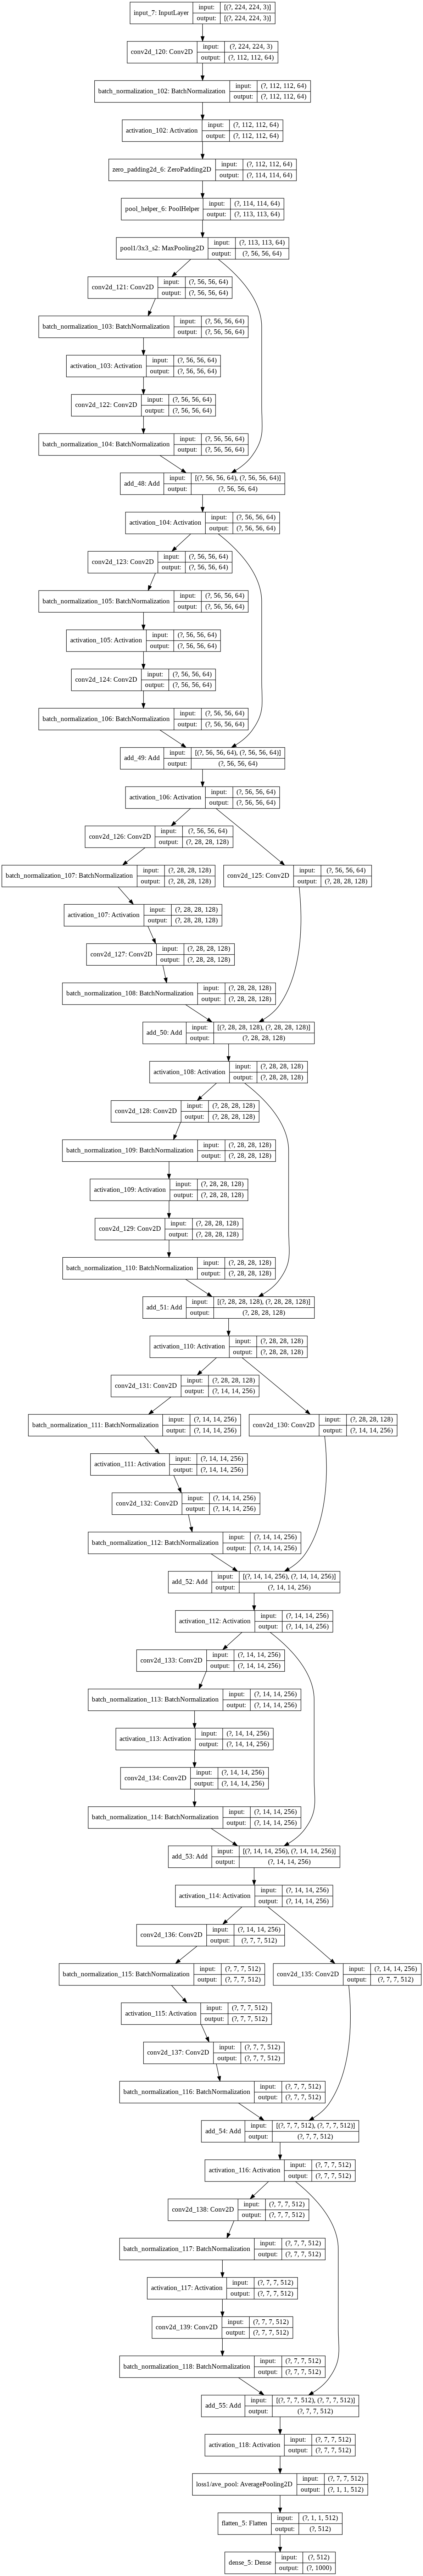

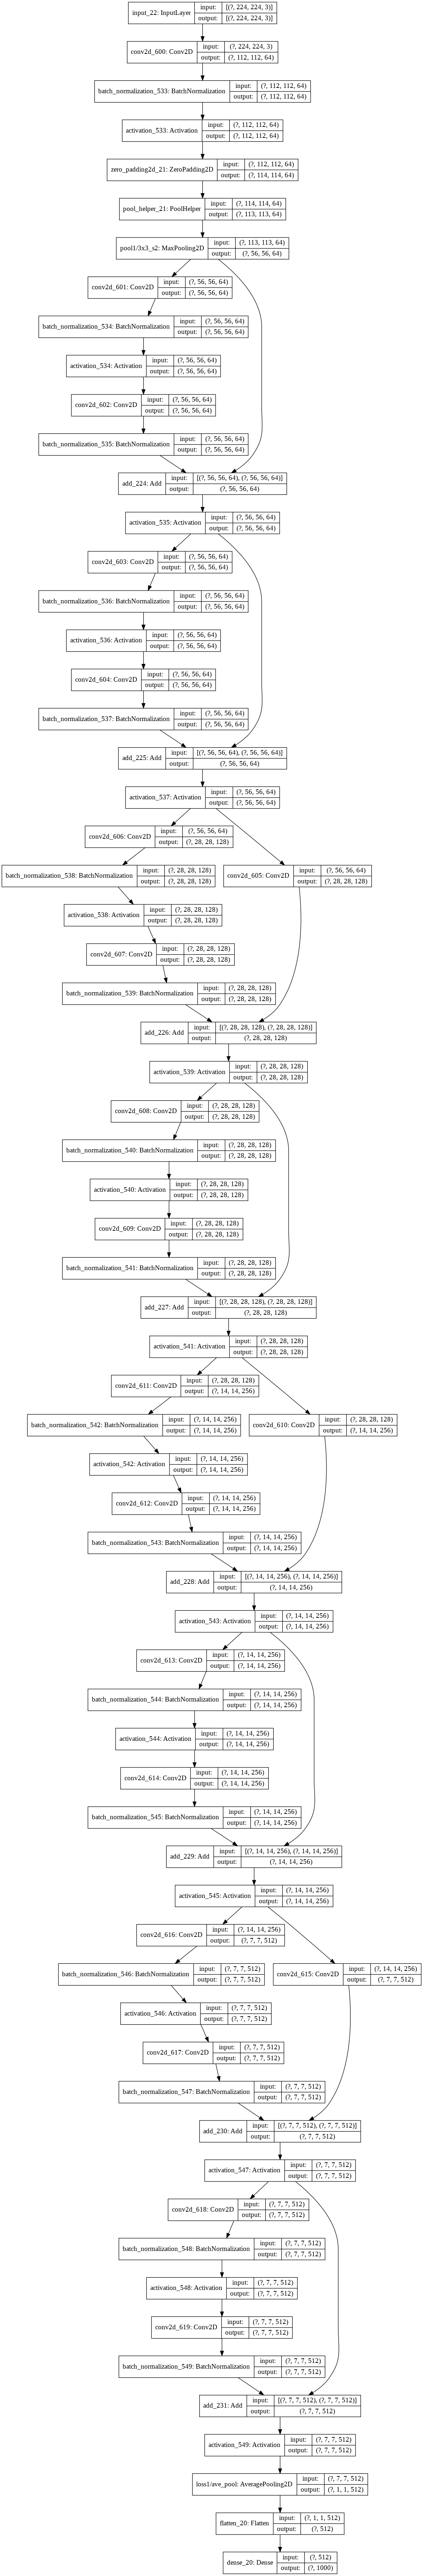

In [158]:
plot_model(model, to_file='model_shapes.png', show_shapes=True) #현재 경로에 저장

## 3. My Function
---

In [0]:
# my resnet start <--  내가 이 아래에서 계속 사용할 모형

# 1. 224의 대략 1/4 연산인 64로 이미지사이즈를 재조정한다.
# 2. Conv의 filter는 1/8로 줄인다.
# 3. 마지막 층 AveragePooling 에서 size를 기존 7 에서 2로 줄인다.
# 4. 다음과 같이 모형을 재구성한다.
# 5. 위의 내용은 앞으로 비교될 모형에서도 공통적으로 작용한다.

# my resnet model (for 18/34/50/101/152 layer)
def my_resnet(input_shape=(64, 64, 3), num_filters=8, classes=7, num_blocks=[0,0,0,0], version = None ):
    # num_blocks 는 list로 받는 인자. conv3_x ~ conv5_x의 block의 수를 앞에서부터 차례로 넣어주면 된다.
    if len(num_blocks) != 4 :
        raise NameError("Please input the number of blocks from conv2_x to conv5_x in the 'num_blocks' variable.")

    if version == "v1" :
        block = block_v1
    elif version == "v2":
        block = block_v2
    else :
        raise NameError("Please input the string 'v1' or 'v2' in the 'version' variable. ")

    inputs = Input(shape=input_shape)

    # conv1
    layer1 = resnet_layer(inputs=inputs, num_filters=num_filters, strides=(2, 2), kernel_size=(7, 7), activation='relu')
    conv1_zero_pad = ZeroPadding2D(padding=(1, 1))(layer1)
    pool1_helper = PoolHelper()(conv1_zero_pad)
    cum_block = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid', name='pool1/3x3_s2')(pool1_helper)
    
    # cum_block 변수에 하나씩 residual block을 누적시켜보자.

    for stack in range(4):
        if stack == 0 :
            # 우리가 누적시킬 변수, cum_block을 정의하고, 이 변수에 누적시켜가면서 모형을 출력한다.

            # 이 아래 for문은 conv2_x
            # 들어가기 전에, block_v2라면 input과 output의 filter size를 동일하게 해주는 작업을 한다. 덧셈이 가능해야 하므로, 반드시!
            if version == 'v2':
                cum_block = Conv2D(4 * num_filters, kernel_size=(1, 1), strides=(1, 1), padding='same',
                                   kernel_initializer='glorot_uniform')(cum_block)
                #cum_block = BatchNormalization()(cum_block) # 모든 conv.뒤에는 bn을 적용.

            for res_block in range(num_blocks[stack]):
                cum_block = block(input_shape=cum_block, num_filters=num_filters, identi=cum_block, half=False)
        else:

            # 이 아래는 conv3_x ~ conv5_x 까지.
            num_filters *= 2
 
            if version == 'v2':
                x = Conv2D(4 * num_filters, kernel_size=(1, 1), strides=(2, 2), padding='valid',
                           kernel_initializer='glorot_uniform')(cum_block)  # block_v2라면, input에 해당하는 x를 덧셈이 가능하게 맞춰준다.
                #x = BatchNormalization()(x) # 모든 conv.뒤에는 bn을 적용.
            else:
                x = Conv2D(num_filters, (1, 1), strides=(2, 2), padding='valid')(cum_block)  # identi_input 에 해당 // rxc가 각각 반토막남.
                #즉, 위 x는 결국 이어질 conv 층의 input임.

            for res_block in range(num_blocks[stack]):
                if res_block == 0:
                    cum_block = block(input_shape=cum_block , num_filters = num_filters , identi=x, half=True) # block 갱신
                else:
                    cum_block = block(input_shape=cum_block , num_filters = num_filters , identi=cum_block , half=False) # block 갱신

    # 마지막 1층
    y = AveragePooling2D(pool_size=(2, 2), strides=(1, 1), name='loss1/ave_pool')(cum_block)
    y = Flatten()(y)
    # pool_size 7-> 2
    outputs = Dense(classes, activation='softmax', kernel_initializer='glorot_uniform')(y)
    model = Model(inputs=inputs, outputs=outputs)

    return model

## 4. For Size = 64,
---

### 1) My ResNet18

In [0]:
# 1) my_resnet18
model = my_resnet(input_shape=(64,64,3),classes=7,num_blocks=[2,2,2,2],version='v1')

In [165]:
model.summary()

Model: "model_22"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_24 (InputLayer)           [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_640 (Conv2D)             (None, 32, 32, 8)    1184        input_24[0][0]                   
__________________________________________________________________________________________________
batch_normalization_567 (BatchN (None, 32, 32, 8)    32          conv2d_640[0][0]                 
__________________________________________________________________________________________________
activation_567 (Activation)     (None, 32, 32, 8)    0           batch_normalization_567[0][0]    
___________________________________________________________________________________________

In [0]:
# 여기는 학습의 효율을 위해. Adam으로 넘어간다.
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001), loss='categorical_crossentropy',
              metrics=['accuracy',macro_f1score,weighted_f1score])

early_stopping = EarlyStopping(monitor = 'val_macro_f1score',patience = 3 , verbose=1,mode='max')
lr_sc = LearningRateScheduler(lr_schedule,verbose=1)

In [167]:
# loss가 stable 하지않기때문에 128에서 512로 batch size 를 늘려서 돌려보았다.
model.fit(x_train_zoom,y_train,batch_size=512, validation_data=(x_valid_zoom,y_valid) , epochs=100,callbacks=[early_stopping,lr_sc])

Train on 28698 samples, validate on 3589 samples
Learning rate:  0.01

Epoch 00001: LearningRateScheduler reducing learning rate to 0.01.
Epoch 1/100
28698/28698 [==============================] - 12s 404us/sample - loss: 1.9560 - acc: 0.2514 - macro_f1score: 0.0045 - weighted_f1score: 7.0131e-04 - val_loss: 26.1844 - val_acc: 0.1610 - val_macro_f1score: 0.0415 - val_weighted_f1score: 0.0071
Learning rate:  0.01

Epoch 00002: LearningRateScheduler reducing learning rate to 0.01.
Epoch 2/100
28698/28698 [==============================] - 3s 98us/sample - loss: 1.7478 - acc: 0.3235 - macro_f1score: 0.0755 - weighted_f1score: 0.0114 - val_loss: 1.8715 - val_acc: 0.3001 - val_macro_f1score: 0.0518 - val_weighted_f1score: 0.0069
Learning rate:  0.01

Epoch 00003: LearningRateScheduler reducing learning rate to 0.01.
Epoch 3/100
28698/28698 [==============================] - 3s 98us/sample - loss: 1.6152 - acc: 0.3963 - macro_f1score: 0.1502 - weighted_f1score: 0.0269 - val_loss: 2.8468 - va

In [168]:
_, acc, mac_f1, wei_f1 = model.evaluate(x_test_zoom,y_test,batch_size=128)
print("\nAccuracy: {:.4f}, Macro F1 Score: {:.4f}, Weighted F1 Score: {:.4f}".format(acc,mac_f1,wei_f1))


3588/3588 [==============================] - 0s 103us/sample - loss: 1.5847 - acc: 0.4100 - macro_f1score: 0.1775 - weighted_f1score: 0.0312

Accuracy: 0.4100, Macro F1 Score: 0.1775, Weighted F1 Score: 0.0312


### 2) My ResNet34

In [0]:
# 2) my resnet34
model = my_resnet(input_shape=(64,64,3),classes=7,num_blocks=[3,4,6,3],version='v1')

In [0]:
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_160 (Conv2D)             (None, 32, 32, 8)    1184        input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_136 (BatchN (None, 32, 32, 8)    32          conv2d_160[0][0]                 
__________________________________________________________________________________________________
activation_136 (Activation)     (None, 32, 32, 8)    0           batch_normalization_136[0][0]    
____________________________________________________________________________________________

In [0]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001), loss='categorical_crossentropy',
              metrics=['accuracy',macro_f1score,weighted_f1score])

early_stopping = EarlyStopping(monitor = 'val_macro_f1score',patience = 3 , verbose=1,mode='max')
lr_sc = LearningRateScheduler(lr_schedule,verbose=1)

In [0]:
model.fit(x_train_zoom,y_train,batch_size=128, validation_data=(x_valid_zoom,y_valid) , epochs=100,callbacks=[early_stopping,lr_sc])

Train on 28698 samples, validate on 3589 samples
Learning rate:  0.01

Epoch 00001: LearningRateScheduler reducing learning rate to 0.01.
Epoch 1/100
28698/28698 [==============================] - 7s 249us/sample - loss: 2.1103 - acc: 0.2490 - macro_f1score: 0.0053 - weighted_f1score: 7.7287e-04 - val_loss: 443.6772 - val_acc: 0.2449 - val_macro_f1score: 0.0551 - val_weighted_f1score: 0.0133
Learning rate:  0.01

Epoch 00002: LearningRateScheduler reducing learning rate to 0.01.
Epoch 2/100
28698/28698 [==============================] - 3s 108us/sample - loss: 1.8328 - acc: 0.3321 - macro_f1score: 0.0803 - weighted_f1score: 0.0135 - val_loss: 2.1618 - val_acc: 0.2588 - val_macro_f1score: 0.0713 - val_weighted_f1score: 0.0162
Learning rate:  0.01

Epoch 00003: LearningRateScheduler reducing learning rate to 0.01.
Epoch 3/100
28698/28698 [==============================] - 3s 107us/sample - loss: 1.6865 - acc: 0.3963 - macro_f1score: 0.1464 - weighted_f1score: 0.0271 - val_loss: 1.7685 - 

In [0]:
_, acc, mac_f1, wei_f1 = model.evaluate(x_test_zoom,y_test,batch_size=128)
print("\nAccuracy: {:.4f}, Macro F1 Score: {:.4f}, Weighted F1 Score: {:.4f}".format(acc,mac_f1,wei_f1))


3588/3588 [==============================] - 0s 83us/sample - loss: 1.8544 - acc: 0.2910 - macro_f1score: 0.0922 - weighted_f1score: 0.0122

Accuracy: 0.2910, Macro F1 Score: 0.0922, Weighted F1 Score: 0.0122


### 3) My ResNet50

In [0]:
# 3) my resnet50 (version = 'v2' -- 언급했다시피, 101층과 152층도 v2이다.)
model = my_resnet(input_shape=(64,64,3),classes=7,num_blocks=[3,4,6,3],version='v2')

In [0]:
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_196 (Conv2D)             (None, 32, 32, 8)    1184        input_10[0][0]                   
__________________________________________________________________________________________________
batch_normalization_169 (BatchN (None, 32, 32, 8)    32          conv2d_196[0][0]                 
__________________________________________________________________________________________________
activation_169 (Activation)     (None, 32, 32, 8)    0           batch_normalization_169[0][0]    
____________________________________________________________________________________________

In [0]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001), loss='categorical_crossentropy',
              metrics=['accuracy',macro_f1score,weighted_f1score])

early_stopping = EarlyStopping(monitor = 'val_macro_f1score',patience = 3 , verbose=1,mode='max')
lr_sc = LearningRateScheduler(lr_schedule,verbose=1)

In [0]:
# loss가 stable 하지않기때문에 128에서 512로 batch size 를 늘려서 돌려보았다.
model.fit(x_train_zoom,y_train,batch_size=512, validation_data=(x_valid_zoom,y_valid) , epochs=100,callbacks=[early_stopping,lr_sc])

Train on 28698 samples, validate on 3589 samples
Learning rate:  0.01

Epoch 00001: LearningRateScheduler reducing learning rate to 0.01.
Epoch 1/100
28698/28698 [==============================] - 11s 380us/sample - loss: 2.5721 - acc: 0.2430 - macro_f1score: 0.0064 - weighted_f1score: 0.0012 - val_loss: 2.1163 - val_acc: 0.2455 - val_macro_f1score: 0.0000e+00 - val_weighted_f1score: 0.0000e+00
Learning rate:  0.01

Epoch 00002: LearningRateScheduler reducing learning rate to 0.01.
Epoch 2/100
28698/28698 [==============================] - 4s 137us/sample - loss: 2.1469 - acc: 0.2466 - macro_f1score: 0.0031 - weighted_f1score: 5.5610e-04 - val_loss: 3.1767 - val_acc: 0.2536 - val_macro_f1score: 0.0164 - val_weighted_f1score: 0.0028
Learning rate:  0.01

Epoch 00003: LearningRateScheduler reducing learning rate to 0.01.
Epoch 3/100
28698/28698 [==============================] - 4s 137us/sample - loss: 2.1480 - acc: 0.2515 - macro_f1score: 0.0040 - weighted_f1score: 7.1063e-04 - val_loss

In [0]:
_, acc, mac_f1, wei_f1 = model.evaluate(x_test_zoom,y_test,batch_size=128)
print("\nAccuracy: {:.4f}, Macro F1 Score: {:.4f}, Weighted F1 Score: {:.4f}".format(acc,mac_f1,wei_f1))

3588/3588 [==============================] - 0s 117us/sample - loss: 1.7953 - acc: 0.3423 - macro_f1score: 0.0785 - weighted_f1score: 0.0182

Accuracy: 0.3423, Macro F1 Score: 0.0785, Weighted F1 Score: 0.0182


## 5. For Size =48,
---

### 1) My ResNet18

In [0]:
#내 데이터 맞춤형 모형
# 1) my resnet18

model = my_resnet(input_shape=(48,48,3),classes=7,num_blocks=[2,2,2,2],version='v1')

In [0]:
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 48, 48, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_249 (Conv2D)             (None, 24, 24, 8)    1184        input_11[0][0]                   
__________________________________________________________________________________________________
batch_normalization_218 (BatchN (None, 24, 24, 8)    32          conv2d_249[0][0]                 
__________________________________________________________________________________________________
activation_218 (Activation)     (None, 24, 24, 8)    0           batch_normalization_218[0][0]    
____________________________________________________________________________________________

In [0]:
# 여기는 학습의 효율을 위해. Adam으로 넘어간다.
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001), loss='categorical_crossentropy',
              metrics=['accuracy',macro_f1score,weighted_f1score])

early_stopping = EarlyStopping(monitor = 'val_macro_f1score',patience = 3 , verbose=1,mode='max')
lr_sc = LearningRateScheduler(lr_schedule,verbose=1)

In [0]:
# loss가 stable 하지않기때문에 128에서 512로 batch size 를 늘려서 돌려보았다.
model.fit(x_train,y_train,batch_size=512, validation_data=(x_valid,y_valid) , epochs=100,callbacks=[early_stopping,lr_sc])

Train on 28698 samples, validate on 3589 samples
Learning rate:  0.01

Epoch 00001: LearningRateScheduler reducing learning rate to 0.01.
Epoch 1/100
28698/28698 [==============================] - 8s 281us/sample - loss: 1.8099 - acc: 0.3111 - macro_f1score: 0.0725 - weighted_f1score: 0.0126 - val_loss: 8.6129 - val_acc: 0.1159 - val_macro_f1score: 0.0260 - val_weighted_f1score: 0.0030
Learning rate:  0.01

Epoch 00002: LearningRateScheduler reducing learning rate to 0.01.
Epoch 2/100
28698/28698 [==============================] - 4s 148us/sample - loss: 1.6162 - acc: 0.3932 - macro_f1score: 0.1463 - weighted_f1score: 0.0277 - val_loss: 1.9092 - val_acc: 0.2953 - val_macro_f1score: 0.0880 - val_weighted_f1score: 0.0142
Learning rate:  0.01

Epoch 00003: LearningRateScheduler reducing learning rate to 0.01.
Epoch 3/100
28698/28698 [==============================] - 4s 150us/sample - loss: 1.5308 - acc: 0.4355 - macro_f1score: 0.1799 - weighted_f1score: 0.0335 - val_loss: 1.9599 - val_ac

In [0]:
_, acc, mac_f1, wei_f1 = model.evaluate(x_test,y_test,batch_size=128)
print("\nAccuracy: {:.4f}, Macro F1 Score: {:.4f}, Weighted F1 Score: {:.4f}".format(acc,mac_f1,wei_f1))


3588/3588 [==============================] - 0s 92us/sample - loss: 1.6468 - acc: 0.4601 - macro_f1score: 0.2769 - weighted_f1score: 0.0488

Accuracy: 0.4601, Macro F1 Score: 0.2769, Weighted F1 Score: 0.0488


### 2) My ResNet34

In [0]:
#내 데이터 맞춤형 모형
# 2) my resnet34
model = my_resnet(input_shape=(48,48,3),classes=7,num_blocks=[3,4,6,3],version='v1')

In [0]:
model.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 48, 48, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_269 (Conv2D)             (None, 24, 24, 8)    1184        input_12[0][0]                   
__________________________________________________________________________________________________
batch_normalization_235 (BatchN (None, 24, 24, 8)    32          conv2d_269[0][0]                 
__________________________________________________________________________________________________
activation_235 (Activation)     (None, 24, 24, 8)    0           batch_normalization_235[0][0]    
___________________________________________________________________________________________

In [0]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001), loss='categorical_crossentropy',
              metrics=['accuracy',macro_f1score,weighted_f1score])

early_stopping = EarlyStopping(monitor = 'val_macro_f1score',patience = 3 , verbose=1,mode='max')
lr_sc = LearningRateScheduler(lr_schedule,verbose=1)

In [0]:
# loss가 stable 하지않기때문에 128에서 512로 batch size 를 늘려서 돌려보았다.
model.fit(x_train,y_train,batch_size=512, validation_data=(x_valid,y_valid) , epochs=100,callbacks=[early_stopping,lr_sc])

Train on 28698 samples, validate on 3589 samples
Learning rate:  0.01

Epoch 00001: LearningRateScheduler reducing learning rate to 0.01.
Epoch 1/100
28698/28698 [==============================] - 11s 372us/sample - loss: 2.0769 - acc: 0.2407 - macro_f1score: 0.0041 - weighted_f1score: 8.0182e-04 - val_loss: 12.9856 - val_acc: 0.1368 - val_macro_f1score: 0.0300 - val_weighted_f1score: 0.0042
Learning rate:  0.01

Epoch 00002: LearningRateScheduler reducing learning rate to 0.01.
Epoch 2/100
28698/28698 [==============================] - 5s 179us/sample - loss: 1.8741 - acc: 0.3066 - macro_f1score: 0.0478 - weighted_f1score: 0.0070 - val_loss: 2.0745 - val_acc: 0.2251 - val_macro_f1score: 0.0497 - val_weighted_f1score: 0.0058
Learning rate:  0.01

Epoch 00003: LearningRateScheduler reducing learning rate to 0.01.
Epoch 3/100
28698/28698 [==============================] - 5s 177us/sample - loss: 1.7442 - acc: 0.3633 - macro_f1score: 0.1218 - weighted_f1score: 0.0222 - val_loss: 2.0776 - 

In [0]:
_, acc, mac_f1, wei_f1 = model.evaluate(x_test,y_test,batch_size=128)
print("\nAccuracy: {:.4f}, Macro F1 Score: {:.4f}, Weighted F1 Score: {:.4f}".format(acc,mac_f1,wei_f1))


3588/3588 [==============================] - 0s 98us/sample - loss: 1.7515 - acc: 0.3554 - macro_f1score: 0.1109 - weighted_f1score: 0.0251

Accuracy: 0.3554, Macro F1 Score: 0.1109, Weighted F1 Score: 0.0251


### 3) My ResNet50

In [0]:
# 내 데이터 맞춤 모형
# 3) my resnet50 (version = 'v2' -- 언급했다시피, 101층과 152층도 v2이다.)
model = my_resnet(input_shape=(48,48,3),classes=7,num_blocks=[3,4,6,3],version='v2')

In [0]:
model.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 48, 48, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_305 (Conv2D)             (None, 24, 24, 8)    1184        input_13[0][0]                   
__________________________________________________________________________________________________
batch_normalization_268 (BatchN (None, 24, 24, 8)    32          conv2d_305[0][0]                 
__________________________________________________________________________________________________
activation_268 (Activation)     (None, 24, 24, 8)    0           batch_normalization_268[0][0]    
___________________________________________________________________________________________

In [0]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001), loss='categorical_crossentropy',
              metrics=['accuracy',macro_f1score,weighted_f1score])

early_stopping = EarlyStopping(monitor = 'val_macro_f1score',patience = 3 , verbose=1,mode='max')
lr_sc = LearningRateScheduler(lr_schedule,verbose=1)

In [0]:
# loss가 stable 하지않기때문에 128에서 512로 batch size 를 늘려서 돌려보았다.
model.fit(x_train,y_train,batch_size=512, validation_data=(x_valid,y_valid) , epochs=100,callbacks=[early_stopping,lr_sc])

Train on 28698 samples, validate on 3589 samples
Learning rate:  0.01

Epoch 00001: LearningRateScheduler reducing learning rate to 0.01.
Epoch 1/100
28698/28698 [==============================] - 14s 496us/sample - loss: 2.4236 - acc: 0.2430 - macro_f1score: 0.0082 - weighted_f1score: 0.0017 - val_loss: 4.0206 - val_acc: 0.1792 - val_macro_f1score: 0.0212 - val_weighted_f1score: 0.0032
Learning rate:  0.01

Epoch 00002: LearningRateScheduler reducing learning rate to 0.01.
Epoch 2/100
28698/28698 [==============================] - 6s 207us/sample - loss: 2.0516 - acc: 0.2736 - macro_f1score: 0.0088 - weighted_f1score: 0.0013 - val_loss: 2.0546 - val_acc: 0.2583 - val_macro_f1score: 0.0000e+00 - val_weighted_f1score: 0.0000e+00
Learning rate:  0.01

Epoch 00003: LearningRateScheduler reducing learning rate to 0.01.
Epoch 3/100
28698/28698 [==============================] - 6s 208us/sample - loss: 1.9516 - acc: 0.3124 - macro_f1score: 0.0595 - weighted_f1score: 0.0100 - val_loss: 1.9521

In [0]:
_, acc, mac_f1, wei_f1 = model.evaluate(x_test,y_test,batch_size=128)
print("\nAccuracy: {:.4f}, Macro F1 Score: {:.4f}, Weighted F1 Score: {:.4f}".format(acc,mac_f1,wei_f1))

3588/3588 [==============================] - 0s 135us/sample - loss: 5.2063 - acc: 0.1792 - macro_f1score: 0.0280 - weighted_f1score: 0.0044

Accuracy: 0.1792, Macro F1 Score: 0.0280, Weighted F1 Score: 0.0044


## 6. For Size = 48, No Early Stopping
---

### 1) Epoch = 50

#### (1) My ResNet18

In [0]:
####################### 이 아래는  early stopping 없이 진행 ###################

In [0]:
# 1) my resnet18
model = my_resnet(input_shape=(48,48,3),classes=7,num_blocks=[2,2,2,2],version='v1')

In [0]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001), loss='categorical_crossentropy',
              metrics=['accuracy',macro_f1score,weighted_f1score])
lr_sc = LearningRateScheduler(lr_schedule,verbose=1)

In [0]:
model.fit(x_train,y_train,batch_size=128, validation_data=(x_valid,y_valid) , epochs=50,callbacks=[lr_sc]) #early stopping 없음.

Train on 28698 samples, validate on 3589 samples
Learning rate:  0.01

Epoch 00001: LearningRateScheduler reducing learning rate to 0.01.
Epoch 1/50
28698/28698 [==============================] - 13s 447us/sample - loss: 1.7401 - acc: 0.3344 - macro_f1score: 0.0901 - weighted_f1score: 0.0173 - val_loss: 2.4076 - val_acc: 0.2485 - val_macro_f1score: 0.0893 - val_weighted_f1score: 0.0162
Learning rate:  0.01

Epoch 00002: LearningRateScheduler reducing learning rate to 0.01.
Epoch 2/50
28698/28698 [==============================] - 7s 260us/sample - loss: 1.5649 - acc: 0.4147 - macro_f1score: 0.1652 - weighted_f1score: 0.0315 - val_loss: 1.7724 - val_acc: 0.3834 - val_macro_f1score: 0.1732 - val_weighted_f1score: 0.0326
Learning rate:  0.01

Epoch 00003: LearningRateScheduler reducing learning rate to 0.01.
Epoch 3/50
28698/28698 [==============================] - 7s 254us/sample - loss: 1.5009 - acc: 0.4437 - macro_f1score: 0.1977 - weighted_f1score: 0.0365 - val_loss: 1.6920 - val_acc:

In [0]:
_, acc, mac_f1, wei_f1 = model.evaluate(x_test,y_test,batch_size=128)
print("\nAccuracy: {:.4f}, Macro F1 Score: {:.4f}, Weighted F1 Score: {:.4f}".format(acc,mac_f1,wei_f1))

3588/3588 [==============================] - 0s 99us/sample - loss: 2.7072 - acc: 0.5070 - macro_f1score: 0.4547 - weighted_f1score: 0.0712

Accuracy: 0.5070, Macro F1 Score: 0.4547, Weighted F1 Score: 0.0712


#### (2) My ResNet34

In [0]:
# 2) my resnet34
model = my_resnet(input_shape=(48,48,3),classes=7,num_blocks=[3,4,6,3],version='v1')

In [0]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001), loss='categorical_crossentropy',
              metrics=['accuracy',macro_f1score,weighted_f1score])
lr_sc = LearningRateScheduler(lr_schedule,verbose=1)

In [0]:
model.fit(x_train,y_train,batch_size=128, validation_data=(x_valid,y_valid) , epochs=50,callbacks=[lr_sc]) #early stopping 없음.

Train on 28698 samples, validate on 3589 samples
Learning rate:  0.01

Epoch 00001: LearningRateScheduler reducing learning rate to 0.01.
Epoch 1/50
28698/28698 [==============================] - 17s 576us/sample - loss: 1.8756 - acc: 0.3102 - macro_f1score: 0.0763 - weighted_f1score: 0.0141 - val_loss: 1.8456 - val_acc: 0.2909 - val_macro_f1score: 0.1121 - val_weighted_f1score: 0.0201
Learning rate:  0.01

Epoch 00002: LearningRateScheduler reducing learning rate to 0.01.
Epoch 2/50
28698/28698 [==============================] - 10s 335us/sample - loss: 1.6547 - acc: 0.3900 - macro_f1score: 0.1504 - weighted_f1score: 0.0281 - val_loss: 1.6776 - val_acc: 0.3787 - val_macro_f1score: 0.1821 - val_weighted_f1score: 0.0344
Learning rate:  0.01

Epoch 00003: LearningRateScheduler reducing learning rate to 0.01.
Epoch 3/50
28698/28698 [==============================] - 9s 323us/sample - loss: 1.5785 - acc: 0.4148 - macro_f1score: 0.1705 - weighted_f1score: 0.0318 - val_loss: 1.6794 - val_acc

In [0]:
_, acc, mac_f1, wei_f1 = model.evaluate(x_test,y_test,batch_size=128)
print("\nAccuracy: {:.4f}, Macro F1 Score: {:.4f}, Weighted F1 Score: {:.4f}".format(acc,mac_f1,wei_f1))

3588/3588 [==============================] - 0s 119us/sample - loss: 2.8761 - acc: 0.5067 - macro_f1score: 0.4487 - weighted_f1score: 0.0731

Accuracy: 0.5067, Macro F1 Score: 0.4487, Weighted F1 Score: 0.0731


#### (3) My ResNet50

In [0]:
# 3) my resnet50(version = 'v2' -- 언급했다시피, 101층과 152층도 v2이다.)
model = my_resnet(input_shape=(48,48,3),classes=7,num_blocks=[3,4,6,3],version='v2')

In [0]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001), loss='categorical_crossentropy',
              metrics=['accuracy',macro_f1score,weighted_f1score])
lr_sc = LearningRateScheduler(lr_schedule,verbose=1)

In [0]:
model.fit(x_train,y_train,batch_size=128, validation_data=(x_valid,y_valid) , epochs=50,callbacks=[lr_sc]) #early stopping 없음.

Train on 28698 samples, validate on 3589 samples
Learning rate:  0.01

Epoch 00001: LearningRateScheduler reducing learning rate to 0.01.
Epoch 1/50
28698/28698 [==============================] - 22s 751us/sample - loss: 2.2229 - acc: 0.2483 - macro_f1score: 0.0037 - weighted_f1score: 6.1964e-04 - val_loss: 18.6865 - val_acc: 0.2382 - val_macro_f1score: 0.0460 - val_weighted_f1score: 0.0116
Learning rate:  0.01

Epoch 00002: LearningRateScheduler reducing learning rate to 0.01.
Epoch 2/50
28698/28698 [==============================] - 11s 397us/sample - loss: 1.9218 - acc: 0.3022 - macro_f1score: 0.0360 - weighted_f1score: 0.0075 - val_loss: 1.8431 - val_acc: 0.3240 - val_macro_f1score: 0.0904 - val_weighted_f1score: 0.0185
Learning rate:  0.01

Epoch 00003: LearningRateScheduler reducing learning rate to 0.01.
Epoch 3/50
28698/28698 [==============================] - 11s 399us/sample - loss: 1.7943 - acc: 0.3429 - macro_f1score: 0.1018 - weighted_f1score: 0.0193 - val_loss: 1.8303 - v

In [0]:
_, acc, mac_f1, wei_f1 = model.evaluate(x_test,y_test,batch_size=128)
print("\nAccuracy: {:.4f}, Macro F1 Score: {:.4f}, Weighted F1 Score: {:.4f}".format(acc,mac_f1,wei_f1))

3588/3588 [==============================] - 1s 156us/sample - loss: 2.2286 - acc: 0.4883 - macro_f1score: 0.4267 - weighted_f1score: 0.0684

Accuracy: 0.4883, Macro F1 Score: 0.4267, Weighted F1 Score: 0.0684


### 1) Epoch = 100

#### (1) My ResNet18

In [0]:
# epoch = 100

In [0]:
# 1) my resnet18
model = my_resnet(input_shape=(48,48,3),classes=7,num_blocks=[2,2,2,2],version='v1')

In [0]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001), loss='categorical_crossentropy',
              metrics=['accuracy',macro_f1score,weighted_f1score])
lr_sc = LearningRateScheduler(lr_schedule,verbose=1)

In [0]:
model.fit(x_train,y_train,batch_size=128, validation_data=(x_valid,y_valid) , epochs=100,callbacks=[lr_sc]) #early stopping 없음.

Train on 28698 samples, validate on 3589 samples
Learning rate:  0.01

Epoch 00001: LearningRateScheduler reducing learning rate to 0.01.
Epoch 1/100
28698/28698 [==============================] - 15s 508us/sample - loss: 1.7299 - acc: 0.3440 - macro_f1score: 0.0951 - weighted_f1score: 0.0181 - val_loss: 1.8658 - val_acc: 0.3129 - val_macro_f1score: 0.1228 - val_weighted_f1score: 0.0193
Learning rate:  0.01

Epoch 00002: LearningRateScheduler reducing learning rate to 0.01.
Epoch 2/100
28698/28698 [==============================] - 8s 273us/sample - loss: 1.5534 - acc: 0.4175 - macro_f1score: 0.1691 - weighted_f1score: 0.0319 - val_loss: 1.8650 - val_acc: 0.3371 - val_macro_f1score: 0.1511 - val_weighted_f1score: 0.0287
Learning rate:  0.01

Epoch 00003: LearningRateScheduler reducing learning rate to 0.01.
Epoch 3/100
28698/28698 [==============================] - 8s 279us/sample - loss: 1.4852 - acc: 0.4485 - macro_f1score: 0.2005 - weighted_f1score: 0.0372 - val_loss: 1.7055 - val_a

In [0]:
_, acc, mac_f1, wei_f1 = model.evaluate(x_test,y_test,batch_size=128)
print("\nAccuracy: {:.4f}, Macro F1 Score: {:.4f}, Weighted F1 Score: {:.4f}".format(acc,mac_f1,wei_f1))

3588/3588 [==============================] - 0s 111us/sample - loss: 3.1770 - acc: 0.5061 - macro_f1score: 0.4498 - weighted_f1score: 0.0706

Accuracy: 0.5061, Macro F1 Score: 0.4498, Weighted F1 Score: 0.0706


#### (2) My ResNet34

In [0]:
# 2) my resnet34
model = my_resnet(input_shape=(48,48,3),classes=7,num_blocks=[2,2,2,2],version='v1')

In [0]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001), loss='categorical_crossentropy',
              metrics=['accuracy',macro_f1score,weighted_f1score])
lr_sc = LearningRateScheduler(lr_schedule,verbose=1)

In [0]:
model.fit(x_train,y_train,batch_size=128, validation_data=(x_valid,y_valid) , epochs=100,callbacks=[lr_sc]) #early stopping 없음.

Train on 28698 samples, validate on 3589 samples
Learning rate:  0.01

Epoch 00001: LearningRateScheduler reducing learning rate to 0.01.
Epoch 1/100
28698/28698 [==============================] - 15s 527us/sample - loss: 1.7299 - acc: 0.3467 - macro_f1score: 0.1004 - weighted_f1score: 0.0187 - val_loss: 1.8295 - val_acc: 0.3449 - val_macro_f1score: 0.1517 - val_weighted_f1score: 0.0282
Learning rate:  0.01

Epoch 00002: LearningRateScheduler reducing learning rate to 0.01.
Epoch 2/100
28698/28698 [==============================] - 8s 271us/sample - loss: 1.5731 - acc: 0.4153 - macro_f1score: 0.1652 - weighted_f1score: 0.0312 - val_loss: 1.5839 - val_acc: 0.4202 - val_macro_f1score: 0.1503 - val_weighted_f1score: 0.0274
Learning rate:  0.01

Epoch 00003: LearningRateScheduler reducing learning rate to 0.01.
Epoch 3/100
28698/28698 [==============================] - 8s 271us/sample - loss: 1.5030 - acc: 0.4461 - macro_f1score: 0.2058 - weighted_f1score: 0.0377 - val_loss: 1.5298 - val_a

In [0]:
_, acc, mac_f1, wei_f1 = model.evaluate(x_test,y_test,batch_size=128)
print("\nAccuracy: {:.4f}, Macro F1 Score: {:.4f}, Weighted F1 Score: {:.4f}".format(acc,mac_f1,wei_f1))

3588/3588 [==============================] - 0s 107us/sample - loss: 3.1972 - acc: 0.5059 - macro_f1score: 0.4543 - weighted_f1score: 0.0726

Accuracy: 0.5059, Macro F1 Score: 0.4543, Weighted F1 Score: 0.0726


#### (3) My ResNet50

In [0]:
# 3) my resnet50(version = 'v2' -- 언급했다시피, 101층과 152층도 v2이다.)
model = my_resnet(input_shape=(48,48,3),classes=7,num_blocks=[3,4,6,3],version='v2')

In [0]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001), loss='categorical_crossentropy',
              metrics=['accuracy',macro_f1score,weighted_f1score])
lr_sc = LearningRateScheduler(lr_schedule,verbose=1)

In [0]:
model.fit(x_train,y_train,batch_size=128, validation_data=(x_valid,y_valid) , epochs=100,callbacks=[lr_sc]) #early stopping 없음.

Train on 28698 samples, validate on 3589 samples
Learning rate:  0.01

Epoch 00001: LearningRateScheduler reducing learning rate to 0.01.
Epoch 1/100
28698/28698 [==============================] - 22s 775us/sample - loss: 2.2432 - acc: 0.2503 - macro_f1score: 0.0062 - weighted_f1score: 0.0012 - val_loss: 2.0534 - val_acc: 0.2279 - val_macro_f1score: 0.0000e+00 - val_weighted_f1score: 0.0000e+00
Learning rate:  0.01

Epoch 00002: LearningRateScheduler reducing learning rate to 0.01.
Epoch 2/100
28698/28698 [==============================] - 11s 388us/sample - loss: 1.9546 - acc: 0.2948 - macro_f1score: 0.0357 - weighted_f1score: 0.0057 - val_loss: 1.9740 - val_acc: 0.2352 - val_macro_f1score: 0.0184 - val_weighted_f1score: 0.0025
Learning rate:  0.01

Epoch 00003: LearningRateScheduler reducing learning rate to 0.01.
Epoch 3/100
28698/28698 [==============================] - 11s 388us/sample - loss: 1.8018 - acc: 0.3464 - macro_f1score: 0.1014 - weighted_f1score: 0.0188 - val_loss: 1.77

In [0]:
_, acc, mac_f1, wei_f1 = model.evaluate(x_test,y_test,batch_size=128)
print("\nAccuracy: {:.4f}, Macro F1 Score: {:.4f}, Weighted F1 Score: {:.4f}".format(acc,mac_f1,wei_f1))

3588/3588 [==============================] - 0s 139us/sample - loss: 2.8764 - acc: 0.5098 - macro_f1score: 0.4468 - weighted_f1score: 0.0705

Accuracy: 0.5098, Macro F1 Score: 0.4468, Weighted F1 Score: 0.0705
